In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation

2024-01-12 10:36:43.395604: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 10:36:43.395679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 10:36:43.396629: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 10:36:43.402887: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 10:36:44.283697: W tensorflow/compiler/tf2

In [2]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:15]}

In [3]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

label_features=['EW', 'EW_Node_Location', 'NS', 'NS_Node_Location']

ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=input_features_reduced,
                                      label_features=label_features,
                                      train_val_split=0.8, stride=1, input_stride=2, padding='zero',
                                      input_history_steps=40, input_future_steps=40, seed=69)

=========================Creating Dataset=========================
Seed: 69
nTrain: 200 nVal: 50 (0.80)
Padding: zero
Scaling: True 
Horizons: 40-40 @ stride 2
Sin-Transformed features: ['True Anomaly (deg)', 'Argument of Periapsis (deg)']
Labels: ['EW_encoded', 'EW_Node_Location', 'NS_encoded', 'NS_Node_Location']


2024-01-12 10:36:56.050833: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 10:36:56.076399: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 10:36:56.076469: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 10:36:56.078886: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 10:36:56.078989: I external/local_xla/xla/stream_executor

=========================Finished Dataset=========================


In [4]:
train_combined, val_combined = ds_gen.get_datasets(batch_size=512, label_features=['EW', 'NS'], keep_identifier=False, shuffle=True)
# train_combined = train_combined.filter(lambda x,y:y['EW_Node_Location']==1)
# val_combined = val_combined.filter(lambda x,y:y['EW_Node_Location']==1)
# train_combined = train_combined.map(lambda x,y:(x,{'EW':y['EW']}))
# val_combined = val_combined.map(lambda x,y:(x,{'EW':y['EW']}))
# train_combined = train_combined.batch(32)
# val_combined = val_combined.batch(32)
print(train_combined.element_spec)

(TensorSpec(shape=(None, 40, 9), dtype=tf.float64, name=None), {'EW': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'NS': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 40, 9)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 40, 48)               11136     ['Input[0][0]']               
                                                                                                  
 dropout (Dropout)           (None, 40, 48)               0         ['lstm[0][0]']                
                                                                                                  
 lstm_1 (LSTM)               (None, 48)                   18624     ['dropout[0][0]']             
                                                                                              

2024-01-12 10:37:06.477648: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-12 10:37:07.420917: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f973c0ad7d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-12 10:37:07.420968: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-01-12 10:37:07.428012: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705052227.537581    6824 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


852/852 [==============================] - 28s 26ms/step - loss: 3.1165 - EW_loss: 1.3580 - NS_loss: 1.7398 - EW_accuracy: 0.5962 - NS_accuracy: 0.4435 - val_loss: 5.0106 - val_EW_loss: 2.6002 - val_NS_loss: 2.3895 - val_EW_accuracy: 0.5658 - val_NS_accuracy: 0.2879
Epoch 2/20
852/852 [==============================] - 22s 26ms/step - loss: 2.3038 - EW_loss: 1.0107 - NS_loss: 1.2691 - EW_accuracy: 0.6622 - NS_accuracy: 0.5443 - val_loss: 4.8503 - val_EW_loss: 2.4663 - val_NS_loss: 2.3585 - val_EW_accuracy: 0.5978 - val_NS_accuracy: 0.2694
Epoch 3/20
852/852 [==============================] - 21s 25ms/step - loss: 2.1077 - EW_loss: 0.8868 - NS_loss: 1.1928 - EW_accuracy: 0.7053 - NS_accuracy: 0.5665 - val_loss: 4.9025 - val_EW_loss: 2.6862 - val_NS_loss: 2.1868 - val_EW_accuracy: 0.5708 - val_NS_accuracy: 0.4169
Epoch 4/20
852/852 [==============================] - 21s 24ms/step - loss: 2.0295 - EW_loss: 0.8572 - NS_loss: 1.1407 - EW_accuracy: 0.7170 - NS_accuracy: 0.5888 - val_loss: 4.

/home/david/miniconda3/envs/splid-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/david/Code/splid-challenge/base/prediction_models.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


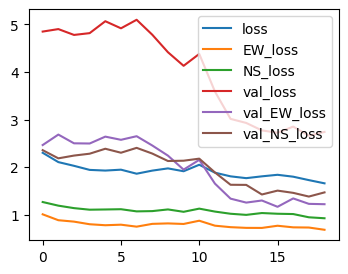

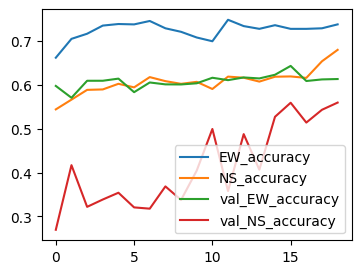

In [5]:
#dense_model = prediction_models.Dense_NN(val_combined, conv1d_layers=[], dense_layers=[256,128,64], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[30000,0.9], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[], dense_layers=[256,128,64,32], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[], seed=0)
dense_model = prediction_models.LSTM_NN(train_combined, input_dropout=0.0, mixed_dropout=0.15, lstm_layers=[48,48], dense_layers=[16], l2_reg=0.0001, lr_scheduler=[25000,0.9], seed=1)

dense_model.summary()
hist = dense_model.fit(train_combined, val_ds=val_combined, epochs=20, verbose=1, plot_hist=False, callbacks=[])
dense_model.model.save('models/ew_ns_classifier_new.hdf5')

dense_model.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
dense_model.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

In [8]:
hist = dense_model.fit(train_combined, val_ds=val_combined, epochs=20, verbose=1, plot_hist=False, callbacks=[])


Starting training. Optimizing "val_accuracy"
Epoch 1/20
852/852 [==============================] - 22s 26ms/step - loss: 1.5454 - EW_loss: 0.6271 - NS_loss: 0.8707 - EW_accuracy: 0.7765 - NS_accuracy: 0.7154 - val_loss: 2.4265 - val_EW_loss: 1.1024 - val_NS_loss: 1.2770 - val_EW_accuracy: 0.6440 - val_NS_accuracy: 0.6105
Epoch 2/20
852/852 [==============================] - 24s 28ms/step - loss: 1.6361 - EW_loss: 0.6746 - NS_loss: 0.9136 - EW_accuracy: 0.7575 - NS_accuracy: 0.6776 - val_loss: 2.8408 - val_EW_loss: 1.2808 - val_NS_loss: 1.5124 - val_EW_accuracy: 0.6138 - val_NS_accuracy: 0.5791
Epoch 3/20
852/852 [==============================] - 23s 27ms/step - loss: 1.4995 - EW_loss: 0.6038 - NS_loss: 0.8466 - EW_accuracy: 0.7822 - NS_accuracy: 0.7180 - val_loss: 2.5713 - val_EW_loss: 1.1571 - val_NS_loss: 1.3650 - val_EW_accuracy: 0.6440 - val_NS_accuracy: 0.6036
Epoch 4/20
852/852 [==============================] - 22s 26ms/step - loss: 1.6004 - EW_loss: 0.6656 - NS_loss: 0.8848 - 

In [6]:
def classification_eval(ds_gen, gt_path, model, train=True):

    t_ds, v_ds = ds_gen.get_datasets(batch_size=None, label_features=label_features, shuffle=False, keep_identifier=True)
    ds = t_ds if train else v_ds
    # only predict on the necessary locations
    ds = ds.filter(lambda x,y,z:y['EW_Node_Location']==1 or y['NS_Node_Location']==1)
    #ds = ds.map(lambda x,y,z:(x,{'EW':y['EW']},z))
    #ds = ds.map(lambda x,y,z:(x,{'EW_Type':y['EW_Type']},z))
    ds = ds.batch(256)

    ground_truth_from_file = pd.read_csv(gt_path).sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
    ground_truth_from_file = ground_truth_from_file[ground_truth_from_file['ObjectID'].isin(map(int, ds_gen.train_keys if train else ds_gen.val_keys))].copy()
    #ground_truth_from_file = ground_truth_from_file[(ground_truth_from_file['Direction'] == 'EW')]
    #ground_truth_from_file[['Node_gt', 'Type_gt']] = ground_truth_from_file[['Node', 'Type']]

    inputs = np.concatenate([element for element in ds.map(lambda x,y,z: x).as_numpy_iterator()])
    #labels = np.concatenate([element['EW_Node_Location'] for element in ds.map(lambda x,y,z: y).as_numpy_iterator()])
    identifiers = np.concatenate([element for element in ds.map(lambda x,y,z: z).as_numpy_iterator()])

    # get predictions
    preds = model.predict(inputs)
    preds_argmax_ew = np.argmax(preds[0], axis=1)
    preds_argmax_ns = np.argmax(preds[1], axis=1)

    df = pd.DataFrame(np.concatenate([identifiers.reshape(-1,2)], axis=1), columns=['ObjectID', 'TimeIndex'], dtype=np.int32)
    df[f'EW_Pred'] = preds_argmax_ew
    df[f'NS_Pred'] = preds_argmax_ns
    df[f'EW_Pred_Decoded'] = ds_gen.combined_label_encoder.inverse_transform(df[f'EW_Pred'])
    df[f'NS_Pred_Decoded'] = ds_gen.combined_label_encoder.inverse_transform(df[f'NS_Pred'])
    df[['Node_EW', 'Type_EW']] = df['EW_Pred_Decoded'].str.split('-', expand=True)
    df[['Node_NS', 'Type_NS']] = df['NS_Pred_Decoded'].str.split('-', expand=True)
    
    
    df_filtered = df.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)

    # now, assign the real label to the locations
    mergeDf = df_filtered.merge(ground_truth_from_file[['ObjectID', 'TimeIndex', 'Direction']], how='right', on = ['ObjectID', 'TimeIndex'])
    
    #mergeDf.loc[(mergeDf['Type'].isna()), 'Type'] = mergeDf['Type_gt'] # Temporary fix as I forgot to use padding
    mergeDf.loc[mergeDf['Direction'] == 'EW', 'Node'] = mergeDf.loc[mergeDf['Direction'] == 'EW', 'Node_EW']
    mergeDf.loc[mergeDf['Direction'] == 'EW', 'Type'] = mergeDf.loc[mergeDf['Direction'] == 'EW', 'Type_EW']
    mergeDf.loc[mergeDf['Direction'] == 'NS', 'Node'] = mergeDf.loc[mergeDf['Direction'] == 'NS', 'Node_NS']
    mergeDf.loc[mergeDf['Direction'] == 'NS', 'Type'] = mergeDf.loc[mergeDf['Direction'] == 'NS', 'Type_NS']
    # For timeindex 0, the node is always SS
    mergeDf.loc[mergeDf['TimeIndex'] == 0, 'Node'] = 'SS'
    # remove ES rows
    mergeDf.dropna(inplace=True)

    evaluator = evaluation.NodeDetectionEvaluator(ground_truth=ground_truth_from_file, participant=mergeDf)
    precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
    print(f'Precision: {precision:.2f}')
    # print(f'Recall: {recall:.2f}')
    # print(f'F2: {f2:.2f}')
    # print(f'RMSE: {rmse:.4}')
    print(f'TP: {total_tp} FP: {total_fp}')

    return mergeDf

In [9]:
eval_df = classification_eval(ds_gen, challenge_data_dir / 'train_labels.csv', dense_model.model, train=False)
print(eval_df.head(20))
# Dense: worse
# LSTM 40-40@2 same-padding: 0.51
# LSTM 40-40@2 zero-padding: 0.49
# LSTM 80-80@5: 0.49

4/4 [==============================] - 0s 9ms/step
Precision: 0.49
TP: 84 FP: 86
    ObjectID  TimeIndex  EW_Pred  NS_Pred EW_Pred_Decoded NS_Pred_Decoded  \
0         10          0     16.0     16.0           SS-CK           SS-CK   
1         10          0     16.0     16.0           SS-CK           SS-CK   
2         10        216     16.0     16.0           SS-CK           SS-CK   
4         15          0     16.0     16.0           SS-CK           SS-CK   
5         15          0     16.0     16.0           SS-CK           SS-CK   
7         21          0     16.0     16.0           SS-CK           SS-CK   
8         21          0     16.0     16.0           SS-CK           SS-CK   
10        26          0     16.0     16.0           SS-CK           SS-CK   
11        26          0     16.0     16.0           SS-CK           SS-CK   
13        30          0     16.0     16.0           SS-CK           SS-CK   
14        30          0     16.0     16.0           SS-CK           SS-C

In [10]:
eval_df = classification_eval(ds_gen, challenge_data_dir / 'train_labels.csv', dense_model.model, train=True)
# LSTM 40-40@2: 0.49
# LSTM 40-40@2 zero-padding: 0.52
# LSTM 80-80@5: 0.51

14/14 [==============================] - 0s 11ms/step
Precision: 0.52
TP: 367 FP: 336


In [12]:
print(ds_gen.val_keys)
import shutil

['10', '104', '114', '115', '116', '119', '121', '123', '137', '139', '148', '15', '160', '161', '167', '171', '176', '184', '185', '193', '198', '199', '21', '211', '212', '221', '222', '227', '230', '233', '235', '238', '241', '245', '26', '30', '36', '45', '47', '50', '52', '60', '61', '66', '67', '73', '84', '87', '88', '91']


In [23]:

labels=pd.read_csv(labels_dir)
print(labels.head(10))
labels = labels.loc[(labels['ObjectID'].isin(map(int, ds_gen.val_keys)))]
labels = labels.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
labels.to_csv('submission/dataset/test_labels.csv', index=False)


   ObjectID  TimeIndex Direction Node Type
0        21          0        EW   SS   HK
1        21          0        NS   SS   HK
2        21       2171        ES   ES   ES
3       198          0        EW   SS   HK
4       198          0        NS   SS   HK
5       198       1249        EW   ID   NK
6       198       1249        NS   ID   NK
7       198       2183        ES   ES   ES
8       136          0        EW   SS   NK
9       136          0        NS   SS   NK
